In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.animation import PillowWriter
import matplotlib.animation as animation

from geexhp.model import datasetup as dset
from geexhp import datavis as dvis
dvis.configure_matplotlib()

In [2]:
modern = dset.combine_parquet("../parallel/data/", keyword="modern", output_file="modern")
proterozoic = dset.combine_parquet("../parallel/data/", keyword="proterozoic", output_file="proterozoic")
archean = dset.combine_parquet("../parallel/data/", keyword="archean", output_file="archean")
# random = dset.combine_parquet("../parallel/data/", keyword="random", output_file="random")

Combined DataFrame saved to ../data/modern_data.parquet
Combined DataFrame saved to ../data/proterozoic_data.parquet
Combined DataFrame saved to ../data/archean_data.parquet


In [3]:
df = pd.concat([modern, proterozoic, archean], ignore_index=True)
df = dset.extract_abundances(df)

In [4]:
df["OBJECT-RADIUS-REL-EARTH"] = df["OBJECT-DIAMETER"].apply(lambda x: (x / (2 * 6378)))

In [35]:
# noise_columns = [col for col in df.columns if "NOISE_" in col]
# mask = ~df[noise_columns].applymap(lambda x: any(value > 10 for value in x)).any(axis=1)
# df = df[mask]

In [5]:
df.to_parquet("../data/data2.parquet", index=False)

In [2]:
df1 = pd.read_parquet("../data/data1.parquet")
df2 = pd.read_parquet("../data/data2.parquet")
df = pd.concat([df1, df2], ignore_index=True)
df.to_parquet("../data/data3.parquet", index=False)

In [2]:
df = pd.read_parquet("../data/data3.parquet")

In [5]:
df["Earth_type"].value_counts()

proterozoic    59926
modern         59720
archean        59629
Name: Earth_type, dtype: int64

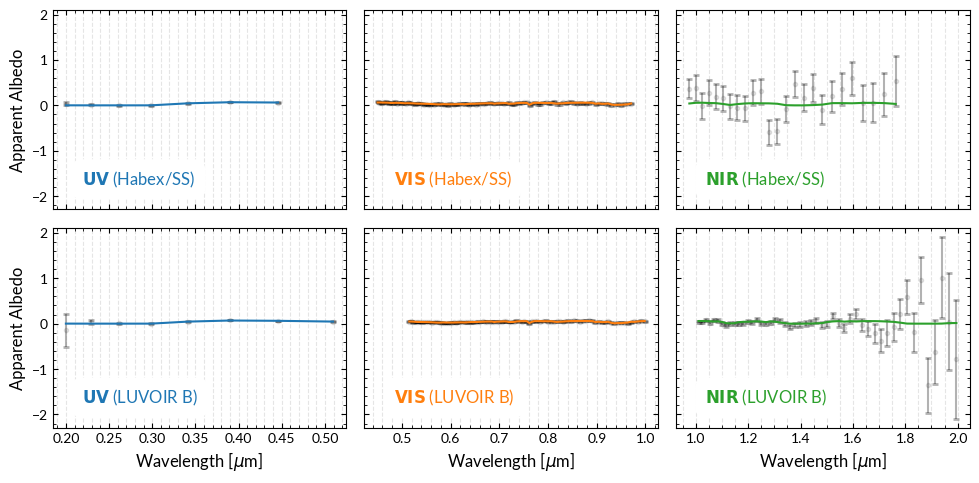

In [9]:
_, ax = plt.subplots(ncols=3, nrows=2, sharey=True, figsize=(10, 5))

for col in range(3):
    ax[1, col].sharex(ax[0, col])

index = np.random.randint(0, len(df))

dvis.plot_spectrum(df, index=index, instruments="SS-UV", ax = ax[0,0], noise=True, 
                show_legend=False, line_color="tab:blue", error_color="k")
dvis.plot_spectrum(df, index=index, instruments="SS-Vis", ax = ax[0,1], noise=True, 
                show_legend=False, line_color="tab:orange", error_color="k")
dvis.plot_spectrum(df, index=index, instruments="SS-NIR", ax = ax[0,2], noise=True, 
                show_legend=False, line_color="tab:green", error_color="k")

dvis.plot_spectrum(df, index=index, instruments="B-UV", ax = ax[1,0], noise=True, 
                show_legend=False, line_color="tab:blue", error_color="k")
dvis.plot_spectrum(df, index=index, instruments="B-Vis", ax = ax[1,1], noise=True, 
                show_legend=False, line_color="tab:orange", error_color="k")
dvis.plot_spectrum(df, index=index, instruments="B-NIR", ax = ax[1,2], noise=True, 
                show_legend=False, line_color="tab:green", error_color="k")

for ax_col in ax[0, :]:
    ax_col.set_xlabel('')           
    ax_col.tick_params(labelbottom=False)  

for ax_row in ax[:, 1:].flatten():
    ax_row.set_ylabel('')            
    ax_row.tick_params(labelleft=False)   

# Add text inside the plots
texts = [
    r"$\mathbf{UV}$ (Habex/SS)", r"$\mathbf{VIS}$ (Habex/SS)", r"$\mathbf{NIR}$ (Habex/SS)",
    r"$\mathbf{UV}$ (LUVOIR B)", r"$\mathbf{VIS}$ (LUVOIR B)", r"$\mathbf{NIR}$ (LUVOIR B)"
]

line_colors = ["tab:blue", "tab:orange", "tab:green", "tab:blue", "tab:orange", "tab:green"]

for i, ax_ in enumerate(ax.flatten()):  # Loop through all axes
    ax_.text(
        0.1, 0.1, texts[i], transform=ax_.transAxes, fontsize=12, va='bottom', ha='left',
        color=line_colors[i],
        bbox=dict(boxstyle="round,pad=0.6", edgecolor='none', facecolor='white')
    )

for ax_row in ax:  # Loop through each row of axes
    for ax_ in ax_row:  # Loop through each Axes in the row
        ax_.grid(True, axis='x', which='both', ls="--", alpha=0.2, color="gray") 

plt.tight_layout()
# plt.savefig("../images/spectrum_example.pdf", bbox_inches='tight');

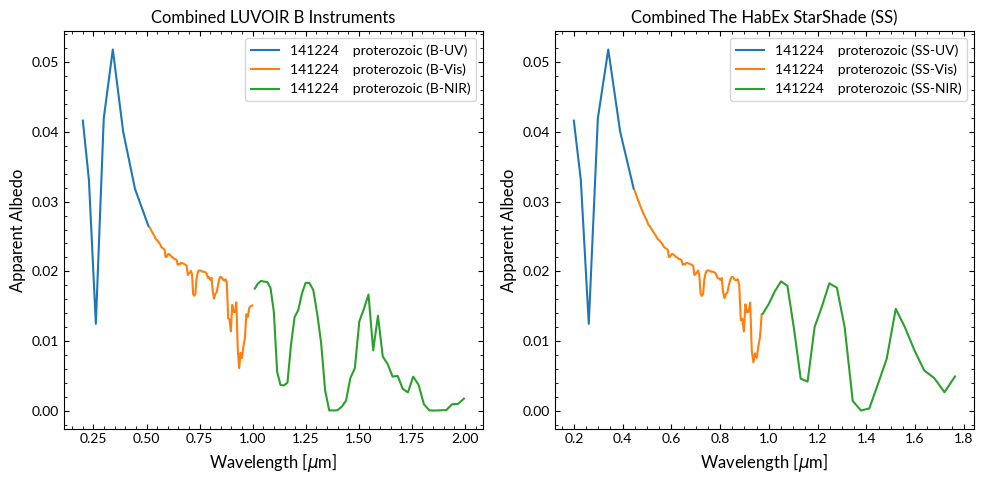

In [10]:
index = np.random.randint(0, len(df))
dvis.plot_spectrum(df, index=index, label=df.iloc[index:index+1]["Earth_type"].to_string());

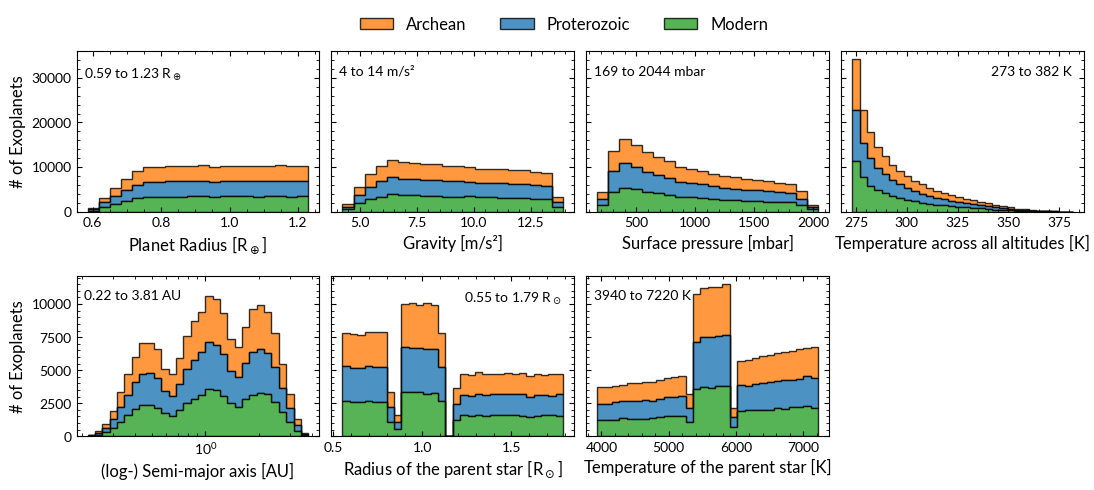

In [11]:
def plothist(column, ylabel, nbins, ax=None, log_scale=False, units="", decimal=0):
    types = df["Earth_type"].unique()
    data = [df[df["Earth_type"] == type_][column] for type_ in types]
    
    # cmap = matplotlib.colormaps.get_cmap("tab20")
    # colors = [cmap(i) for i in range(len(types))]
    colors = ["tab:green", "tab:blue", "tab:orange"]

    if log_scale:
        bin_edges = np.logspace(np.log10(df[column].min()), np.log10(df[column].max()), nbins + 1)
    else:
        bin_edges = np.linspace(df[column].min(), df[column].max(), nbins + 1)

    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = None

    hist = ax.hist(
        data,
        bins=bin_edges,
        stacked=True,
        label=types,
        color=colors,
        alpha=0.8,
        histtype="stepfilled",
        edgecolor="k",
        lw=1,
    )

    if log_scale:
        ax.set_xscale('log')

    ax.set_xlabel(ylabel)

    min_val = df[column].min()
    max_val = df[column].max()
    text = f"\n{min_val:.{decimal}f} to {max_val:.{decimal}f} {units}"

    if column == "OBJECT-STAR-RADIUS" or column == "ATMOSPHERE-TEMPERATURE":
        ax.text(
        0.95, 1, text,
        transform=ax.transAxes,
        fontsize=10,
        verticalalignment='top',
        horizontalalignment='right',
        bbox=dict(facecolor='white', alpha=0, edgecolor='none')
    )
    else:
        ax.text(
            0.03, 1, text,
            transform=ax.transAxes,
            fontsize=10,
            verticalalignment='top',
            horizontalalignment='left',
            bbox=dict(facecolor='white', alpha=0, edgecolor='none')
        )

    return hist, ax, fig

fig, ax = plt.subplots(2, 4, figsize=(13, 5), sharey="row")
fig.subplots_adjust(hspace=0.4, wspace=0.05)


plothist("OBJECT-RADIUS-REL-EARTH", r"Planet Radius [R$_\oplus$]", 20, ax=ax[0, 0], units="R$_\oplus$", decimal=2)
plothist("OBJECT-GRAVITY", "Gravity [m/s²]", 20, ax=ax[0, 1], units="m/s²", decimal=0)
plothist("ATMOSPHERE-PRESSURE", "Surface pressure [mbar]", 20, ax=ax[0, 2], units="mbar", decimal=0)
plothist("ATMOSPHERE-TEMPERATURE", "Temperature across all altitudes [K]", 30, ax=ax[0, 3], units="K", decimal=0)
ax[0,0].set_ylabel("# of Exoplanets")
plothist("OBJECT-STAR-DISTANCE", "(log-) Semi-major axis [AU]", 30, ax=ax[1, 0], log_scale=True, units="AU", decimal=2)
plothist("OBJECT-STAR-RADIUS", "Radius of the parent star [R$_\odot$]", 30, ax=ax[1, 1], units="R$_\odot$", decimal=2)
plothist("OBJECT-STAR-TEMPERATURE", "Temperature of the parent star [K]", 30, ax=ax[1, 2], units="K", decimal=0)
ax[1,0].set_ylabel("# of Exoplanets")

fig.delaxes(ax[1][3])

handles, labels = ax[0, 0].get_legend_handles_labels()
labels = [label.title() for label in labels]
fig.legend(handles, labels, loc='upper center', ncol=4, bbox_to_anchor=(0.5, 0.98), frameon=False, fontsize=12)

#plt.savefig("../images/parameters_distribution.pdf", bbox_inches='tight');

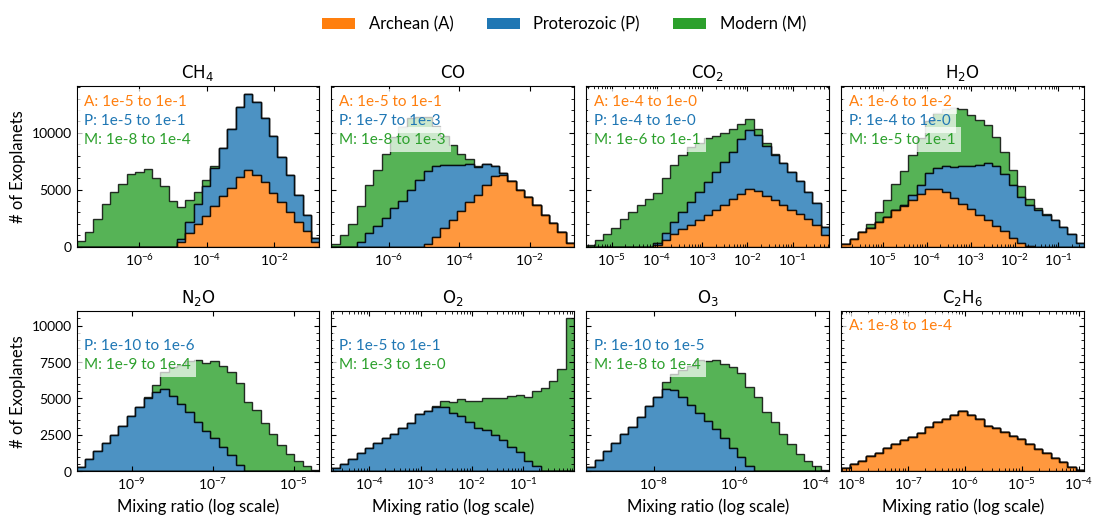

In [12]:
# unique_molecules = [col for col in df.columns[-10:-1] if col != "N2"]
# unique_molecules = ["CO2", "O2", "CH4", "C2H6", "CO", "H2O", "N2O", "O3", "NH3", "H2", "HCN", "PH3"]
unique_molecules = ["CH4", "CO", "CO2", "H2O", "N2O", "O2", "O3", "C2H6"]
# earth_types = df["Earth_type"].unique()
earth_types = ["archean", "proterozoic", "modern"]

fig, axes = plt.subplots(2, 4, figsize=(13, 5), sharey="row")
axes = np.atleast_2d(axes) 
fig.subplots_adjust(hspace=0.4, wspace=0.05)

for row in range(2): 
    axes[row, 0].set_ylabel("# of Exoplanets")

for col in [0, 1, 2, 3]:
    axes[-1, col].set_xlabel("Mixing ratio (log scale)")

colors = ["tab:orange", "tab:blue", "tab:green"]

def format_molecule(molecule):
    formatted = molecule[0] 
    for char in molecule[1:]:
        if char.isdigit():
            formatted += r"_{\mathrm{" + char + "}}"
        else:
            formatted += char  
    return rf"\mathrm{{{formatted}}}"

for i, molecule in enumerate(unique_molecules):
    row, col = divmod(i, 4)  
    ax = axes[row, col]    
    
    data_list = [] 
    labels = []  

    for j, earth_type in enumerate(earth_types):
        subset = df[(df["Earth_type"] == earth_type) & (df[molecule].notna())]
        if not subset.empty:
            data_list.append(subset[molecule])
            labels.append(earth_type)

    non_zero_data_list = [data[data > 0] for data in data_list]

    bins = np.logspace(
        np.log10(min(d.min() for d in non_zero_data_list if len(d) > 0)), 
        np.log10(max(d.max() for d in non_zero_data_list if len(d) > 0)), 
        30
    )
    ax.hist(
        non_zero_data_list,
        bins=bins,
        stacked=True,
        histtype="stepfilled",
        edgecolor="k",
        alpha=0.8,
        color=colors[:len(data_list)],
        label=labels,
        lw=1,
    )
    ax.set_xscale("log")
    ax.set_xlim(bins[0], bins[-1])

    for j, (data, earth_type, color) in enumerate(zip(data_list, labels, colors[:len(data_list)])):
        non_zero_data = data[data > 0]
        if len(non_zero_data) > 0:
            min_val, max_val = non_zero_data.min(), non_zero_data.max()
            range_text = f"{earth_type[0].title()}: 1e-{np.around(abs(np.log10(min_val))):.0f} to 1e-{abs(np.log10(max_val)):.0f}" 
            ax.text(
                0.03, 0.95 - j * 0.12,
                range_text,
                transform=ax.transAxes,
                fontsize=11,
                verticalalignment='top',
                horizontalalignment='left',
                color=color,
                bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'),
            )
    
    ax.set_title(rf"${format_molecule(molecule)}$")
    
for j in range(len(unique_molecules), axes.size):
    fig.delaxes(axes.flatten()[j])

handles = [
    mpatches.Rectangle((0, 0), 2, 1, facecolor=color, edgecolor="k", linewidth=0)
    for color in colors[:len(earth_types)]
]
fig.legend(
    handles, [f"{earth_type.title()} ({earth_type[0].title()})" for earth_type in earth_types],
    loc='upper center', 
    ncol=len(earth_types), 
    bbox_to_anchor=(0.5, 1.05),
    frameon=False,
    fontsize=12
)

# plt.savefig("../images/mixingratio_distribution.pdf", bbox_inches='tight');

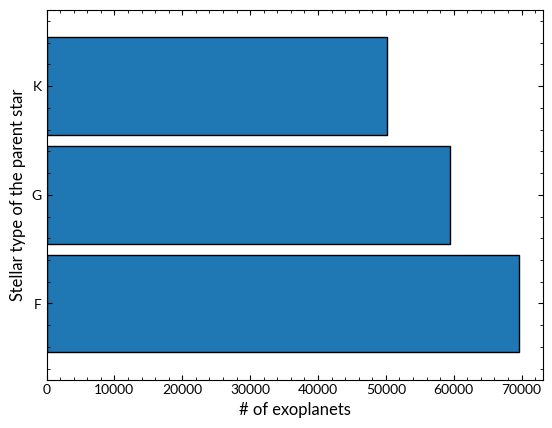

In [13]:
df["OBJECT-STAR-TYPE"].value_counts().plot(kind="barh", grid=False, ec="k", width=0.9)
plt.xticks(rotation=0)
plt.ylabel("Stellar type of the parent star"), plt.xlabel("# of exoplanets");

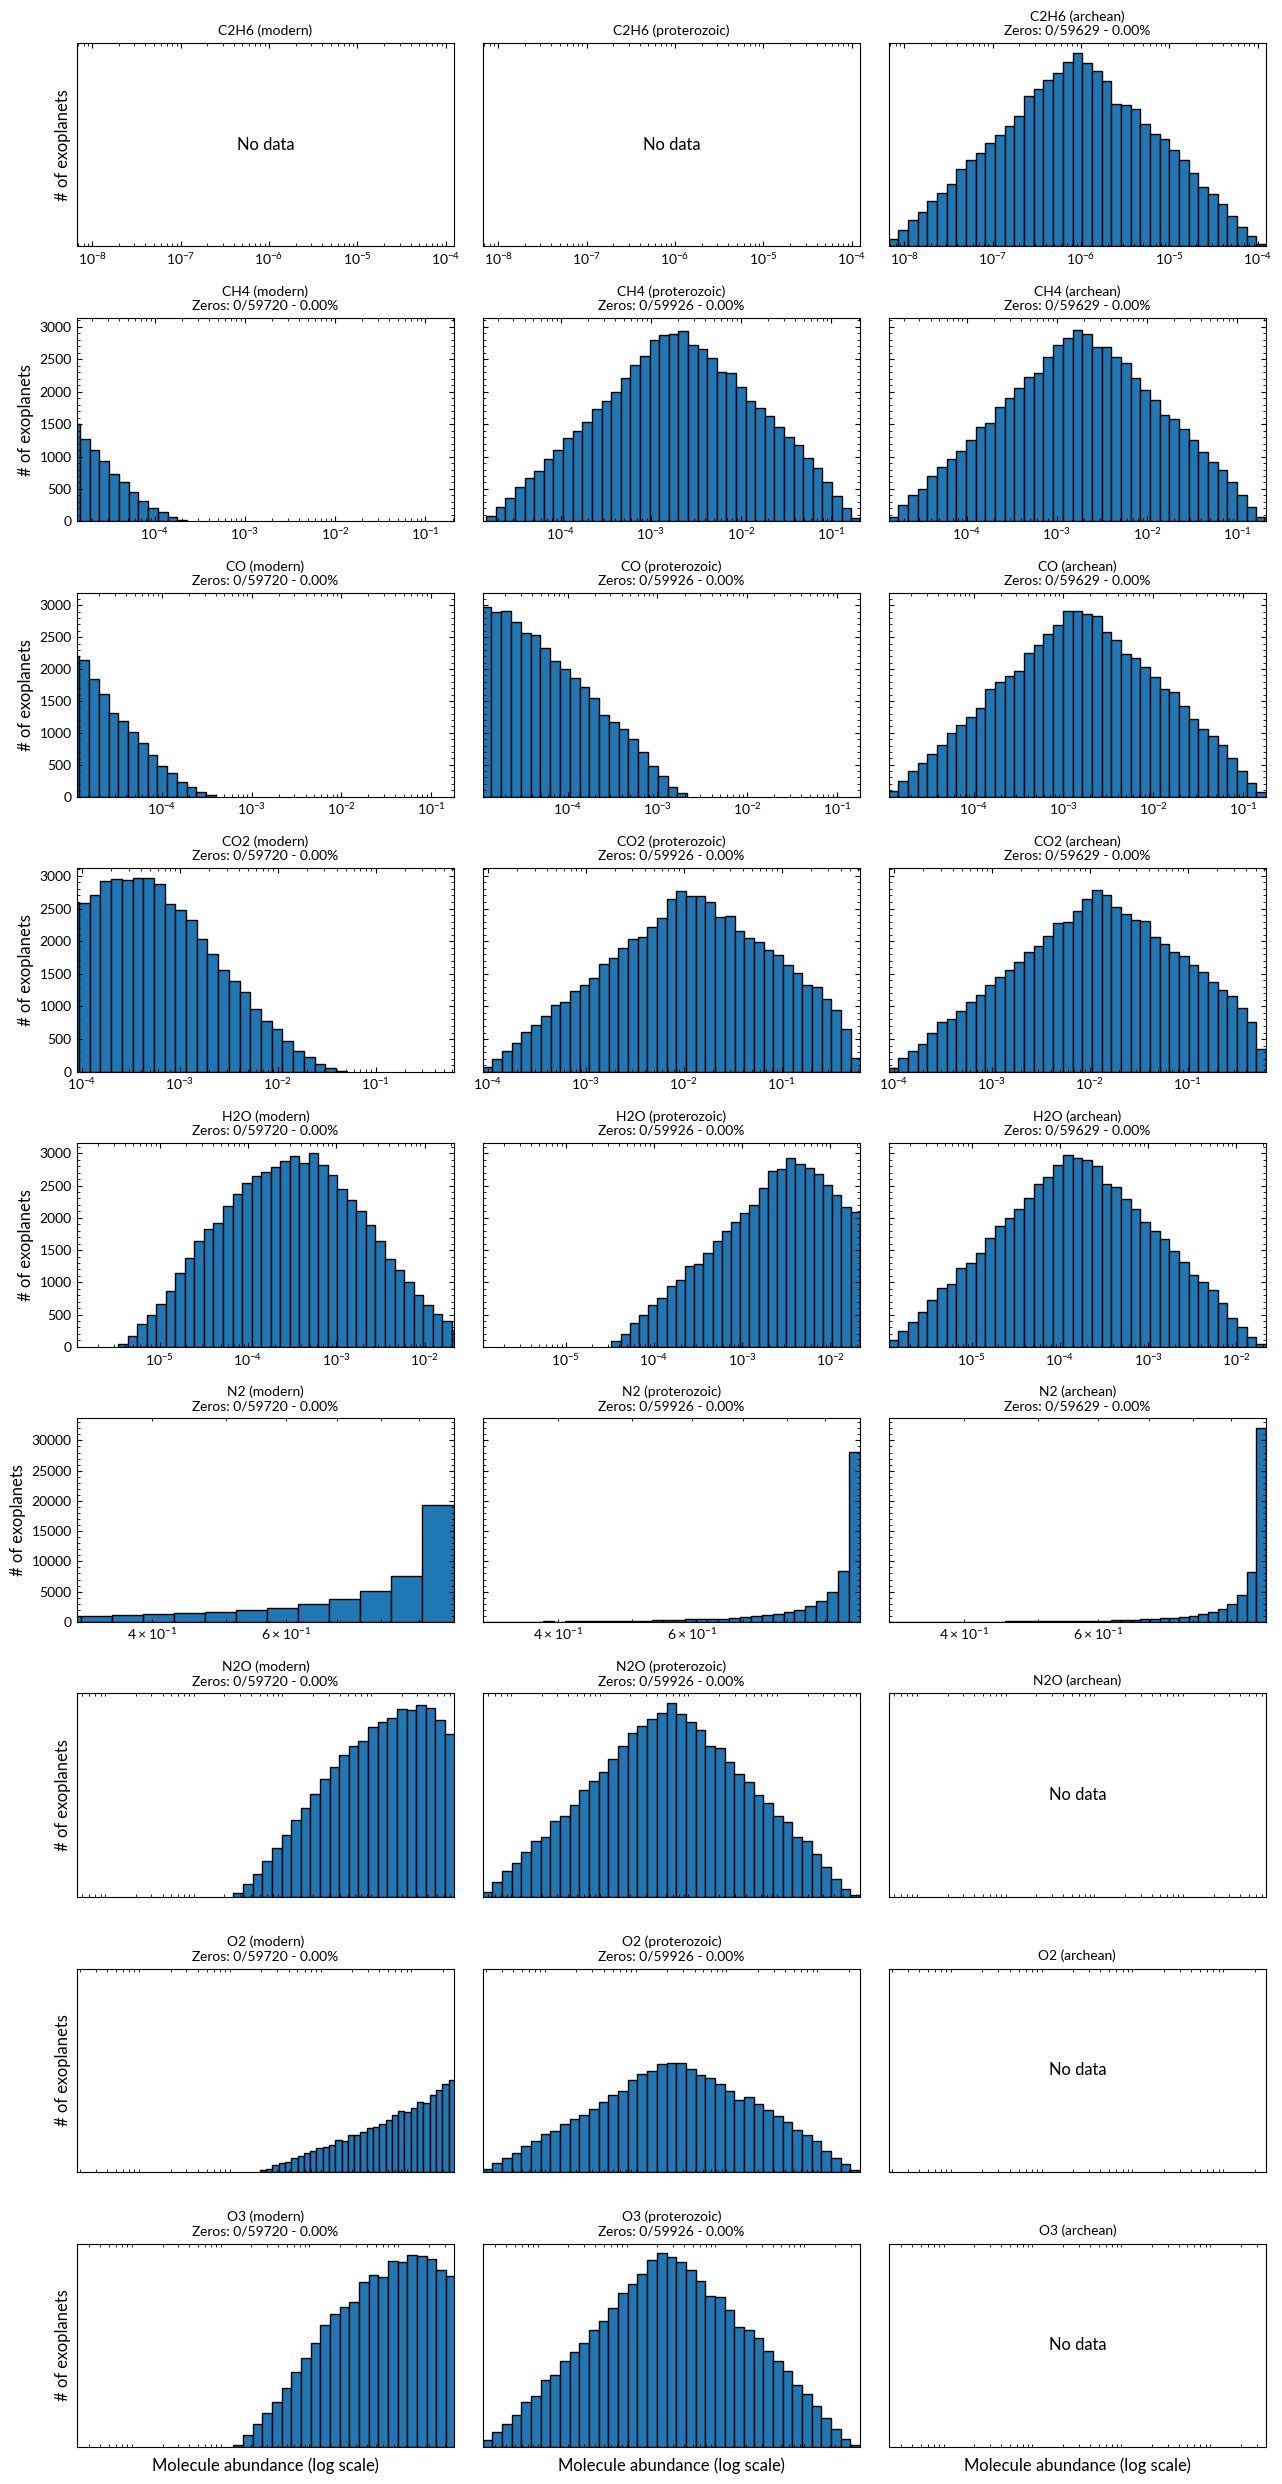

In [17]:
unique_molecules = [col for col in df.columns[-10:-1]]

earth_types = df["Earth_type"].unique()

fig, axes = plt.subplots(len(unique_molecules), len(earth_types), figsize=(13, 25), sharex='row', sharey="row")
axes = np.atleast_2d(axes)

for i, molecule in enumerate(sorted(unique_molecules)):
    for j, earth_type in enumerate(earth_types):
        ax = axes[i, j]
        
        # Filter data for the current molecule and Earth type
        subset = df[(df["Earth_type"] == earth_type) & (df[molecule].notna())] if molecule in df.columns else None
        if subset is not None and not subset.empty:
            data = subset[molecule]
        else:
            data = None

        if data is not None:
            # Compute zero percentages
            zero_count = (data == 0).sum()
            total_count = len(data)
            zero_percentage = (zero_count / total_count) * 100 if total_count > 0 else 0

            # Define non-zero data and log-scale bins
            non_zero_data = data[data > 0]
            if len(non_zero_data) > 0:
                bins = np.logspace(
                    np.log10(non_zero_data.min()), np.log10(non_zero_data.max()), 40
                )
                ax.hist(non_zero_data, bins=bins, edgecolor="k")
                ax.set_xscale("log")
                ax.set_xlim(non_zero_data.min(), non_zero_data.max())
                
                # Set titles and labels
                ax.set_title(
                    f"{molecule} ({earth_type})\nZeros: {zero_count}/{total_count} - {zero_percentage:.2f}%",
                    fontsize=10,
                )
            else:
                ax.text(0.5, 0.5, "No data", ha="center", va="center", transform=ax.transAxes)
                ax.set_xticks([])
                ax.set_yticks([])
                # Set titles and labels
                ax.set_title(f"{molecule} ({earth_type})",fontsize=10)
        else:
            ax.text(0.5, 0.5, f"No data for {molecule} ({earth_type})", ha="center", va="center", transform=ax.transAxes)

        if j == 0:
            ax.set_ylabel("# of exoplanets")
        if i == len(unique_molecules) - 1:
            ax.set_xlabel("Molecule abundance (log scale)")

fig.tight_layout()
# fig.savefig("distribution.pdf", bbox_inches='tight');

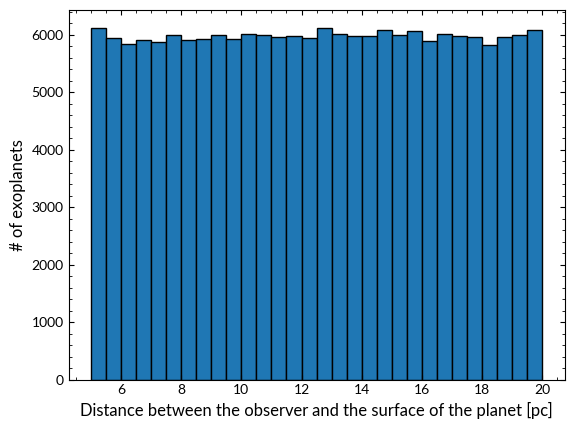

In [18]:
df["GEOMETRY-OBS-ALTITUDE"].hist(ec="k", grid=False, bins=30)
plt.xlabel("Distance between the observer and the surface of the planet [pc]")
plt.ylabel("# of exoplanets");

<Axes: >

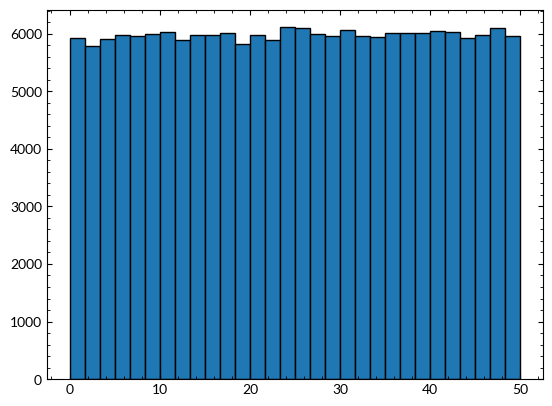

In [19]:
df["OBJECT-INCLINATION"].hist(ec="k", grid=False, bins=30)

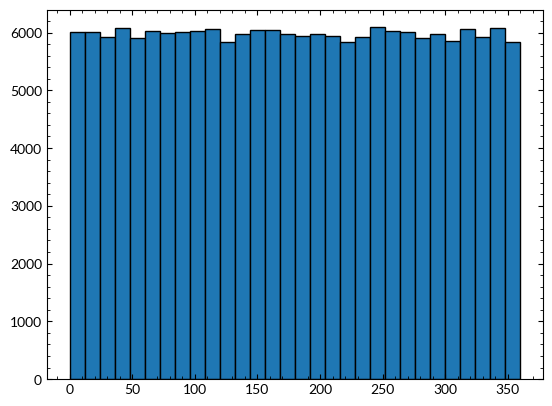

In [20]:
df["OBJECT-SEASON"].hist(ec="k", grid=False, bins=30);

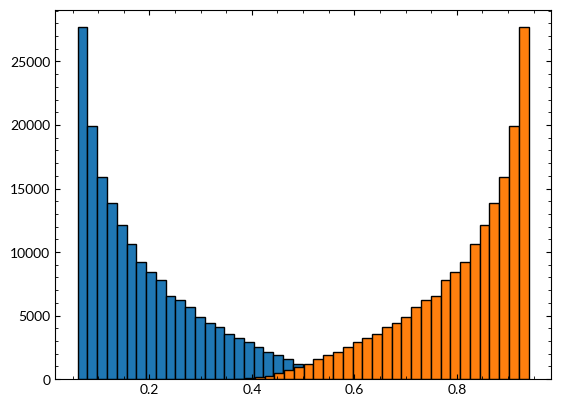

In [21]:
df["SURFACE-ALBEDO"].hist(ec="k", grid=False, bins=30)
df["SURFACE-EMISSIVITY"].hist(ec="k", grid=False, bins=30);

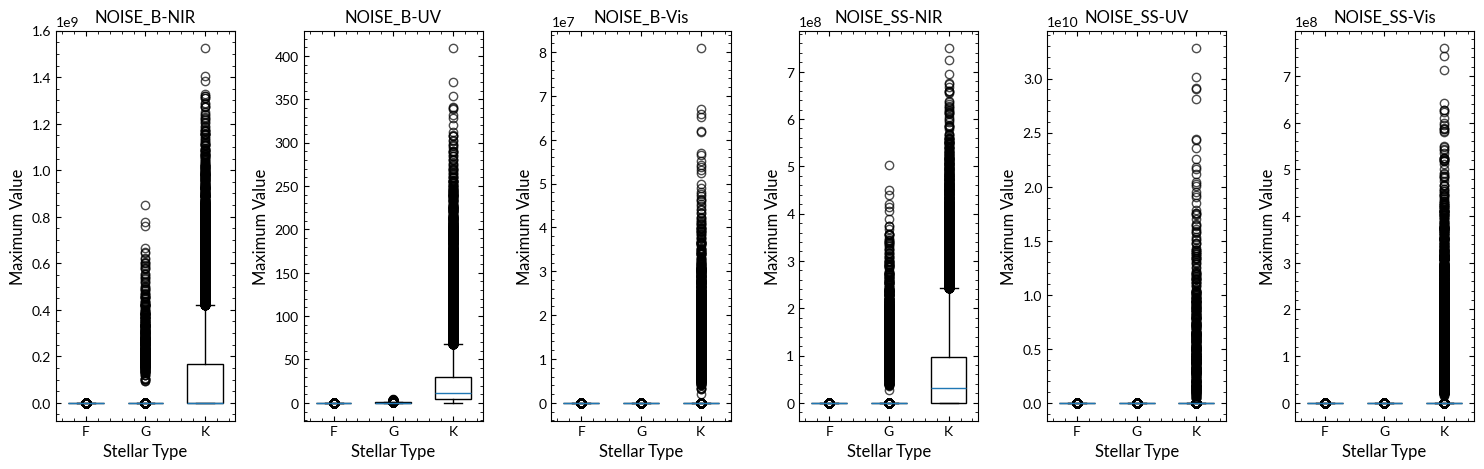

In [30]:
noise_columns = [col for col in df.columns if "NOISE_" in col]
data = df[noise_columns]

max_values_df = pd.DataFrame({
    col: pd.Series(data[col].explode().astype(float).groupby(level=0).max())
    for col in data.columns
})

max_values_df["GEOMETRY-STELLAR-TYPE"] = df["GEOMETRY-STELLAR-TYPE"].values
stellar_types = max_values_df["GEOMETRY-STELLAR-TYPE"].unique()

plt.figure(figsize=(15, 5))
for i, col in enumerate(noise_columns):
    plt.subplot(1, len(noise_columns), i + 1)
    for j, stellar_type in enumerate(stellar_types):
        filtered_values = max_values_df[max_values_df["GEOMETRY-STELLAR-TYPE"] == stellar_type][col]
        bp = plt.boxplot(
            filtered_values.dropna(),
            positions=[j],
            widths=0.6,
            patch_artist=True,
            boxprops=dict(facecolor="white", color='black', linewidth=1),
            medianprops=dict(color='tab:blue', linewidth=1),
            whiskerprops=dict(color='k', linewidth=1),
            capprops=dict(color='k', linewidth=1),
            flierprops=dict(marker='o', color="tab:gray", alpha=0.7)
        )

    plt.title(col)
    plt.xticks(range(len(stellar_types)), stellar_types)
    plt.xlabel("Stellar Type")
    plt.ylabel("Maximum Value")

plt.tight_layout();

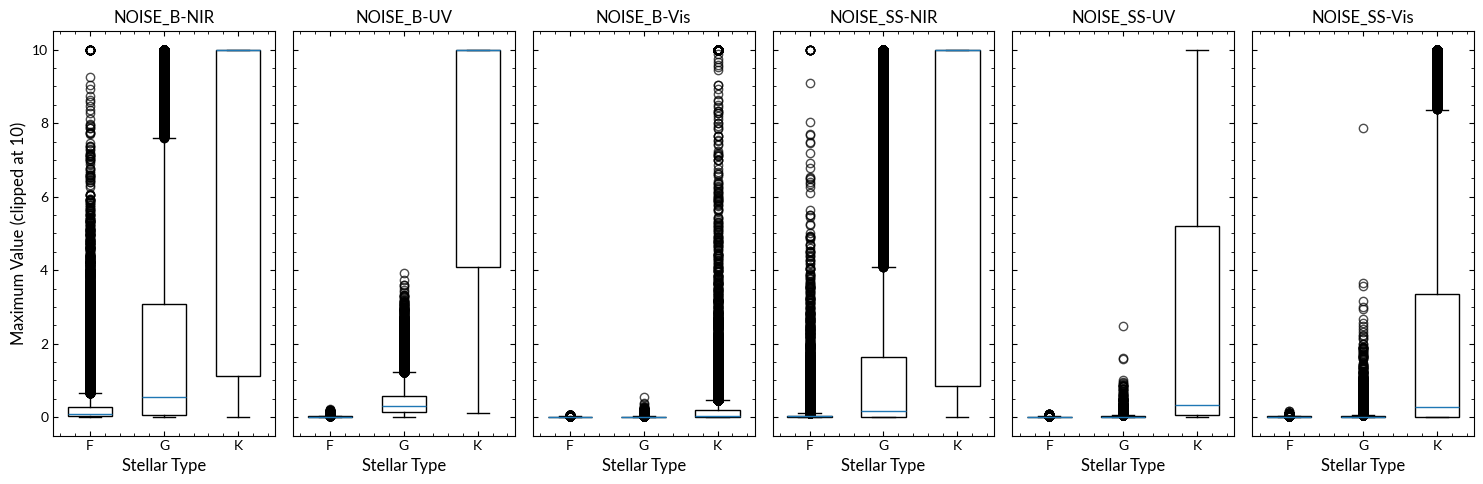

In [34]:
max_values_df = pd.DataFrame({
    col: pd.Series(data[col].explode().astype(float).groupby(level=0).max().clip(upper=10))
    for col in data.columns
})

max_values_df["GEOMETRY-STELLAR-TYPE"] = df["GEOMETRY-STELLAR-TYPE"].values
stellar_types = max_values_df["GEOMETRY-STELLAR-TYPE"].unique()

fig, axes = plt.subplots(1, len(noise_columns), figsize=(15, 5), sharey=True)

for i, (col, ax) in enumerate(zip(noise_columns, axes)):
    for j, stellar_type in enumerate(stellar_types):
        filtered_values = max_values_df[max_values_df["GEOMETRY-STELLAR-TYPE"] == stellar_type][col]
        ax.boxplot(
            filtered_values.dropna(),
            positions=[j],
            widths=0.6,
            patch_artist=True,
            boxprops=dict(facecolor="white", color='black', linewidth=1),
            medianprops=dict(color='tab:blue', linewidth=1),
            whiskerprops=dict(color='k', linewidth=1),
            capprops=dict(color='k', linewidth=1),
            flierprops=dict(marker='o', color="tab:gray", alpha=0.7)
        )

    ax.set_title(col)
    ax.set_xticks(range(len(stellar_types)))
    ax.set_xticklabels(stellar_types)
    ax.set_xlabel("Stellar Type")

axes[0].set_ylabel("Maximum Value (clipped at 10)")

plt.tight_layout();

In [7]:
# noise_ss_columns = [col for col in df.columns if "NOISE_SS" in col]
# noise_b_columns = [col for col in df.columns if "NOISE_B" in col]

# max_noise_values = np.linspace(100, 0.1, 1000)

# extra_frames = 40 
# max_noise_values = np.concatenate([max_noise_values, [max_noise_values[-1]] * extra_frames])

# fig, ax = plt.subplots(figsize=(8, 5))
# bins = 30 

# def update(frame):
#     ax.clear()
#     max_noise = max_noise_values[frame]
    
#     mask_ss = ~df[noise_ss_columns].applymap(lambda x: any(value > max_noise for value in x)).any(axis=1)
#     filtered_df_ss = df[mask_ss]
#     distances_ss = filtered_df_ss["GEOMETRY-OBS-ALTITUDE"]
    
#     mask_b = ~df[noise_b_columns].applymap(lambda x: any(value > max_noise for value in x)).any(axis=1)
#     filtered_df_b = df[mask_b]
#     distances_b = filtered_df_b["GEOMETRY-OBS-ALTITUDE"]
    
#     ax.hist(distances_ss, bins=bins, ec="k", color='tab:blue', label="Habex/SS")
#     ax.hist(distances_b, bins=bins, ec="k", color='tab:orange', label="LUVOIR B")
    
#     ax.set_title(f"Max Noise: {max_noise:.2f}")
#     ax.set_xlabel("Distance between observer and surface of planet [pc]")
#     ax.set_ylabel("# of exoplanets")
#     ax.set_xlim(df["GEOMETRY-OBS-ALTITUDE"].min(), df["GEOMETRY-OBS-ALTITUDE"].max())
#     ax.legend(fontsize=10)

# ani = animation.FuncAnimation(fig, update, frames=len(max_noise_values), repeat=False)
# ani.save("../images/noise_mask_influence.gif", writer=PillowWriter(fps=20))
# plt.close()